### Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt

sb.set()
%matplotlib inline
#%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_squared_error
import lightgbm as lgb

from itertools import product
import calendar 
import gc
import time

from ipywidgets import interact

### Constants

In [2]:
DATA_ENGLISH = False
DATA_PATH    = "../../../datasets/predict-future-sales/"
DATA_ENG_PATH = DATA_PATH+"data eng/"

In [3]:
DATA_ENG_PATH

'../../../datasets/predict-future-sales/data eng/'

### Load data

In [4]:
sales = pd.read_csv(DATA_PATH+"sales_train.csv")          # Dayly sales  Jan 2013 -> Oct 2015
test  = pd.read_csv(DATA_PATH+"test.csv", index_col="ID") # Predict Noviember 2015
sub   = pd.read_csv(DATA_PATH+"sample_submission.csv", index_col="ID")

if DATA_ENGLISH:
    
    shops = pd.read_csv(DATA_ENG_PATH + "shops.csv")           # shops    (60)
    items = pd.read_csv(DATA_ENG_PATH + "items.csv")           # products  (22170)
    cats  = pd.read_csv(DATA_ENG_PATH + "item_categories.csv") # product categories (84)
else:
    shops = pd.read_csv(DATA_PATH+"shops.csv")           # shops    (60)
    items = pd.read_csv(DATA_PATH+"items.csv")           # products  (22170)
    cats  = pd.read_csv(DATA_PATH+"item_categories.csv") # product categories (84)

# <center> PART 1. Data cleaning

# Remove outliers
### Sales with a lot of quatities

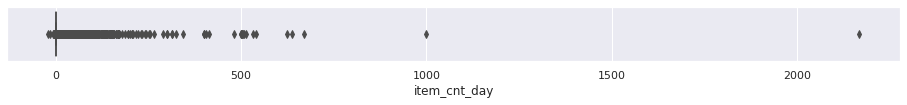

In [5]:
plt.figure(figsize=(16,1))
sb.boxplot(x=sales.item_cnt_day);

### Sales with a expensive items

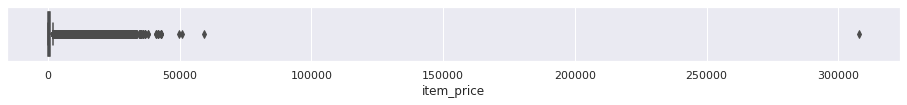

In [6]:
plt.figure(figsize=(16,1))
sb.boxplot(x=sales.item_price);

In [7]:
sales = sales[sales.item_cnt_day<1000]
sales = sales[sales.item_price<100000]

# Correct errors
### Negative prices

In [8]:
sales[sales.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
# See the price for the same item at that shop at that month.
tmp = sales[(sales.shop_id==32)&
      (sales.item_id==2973)&
      (sales.date_block_num==4)&
      (sales.item_price>0)]
tmp

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


In [10]:
# Correct the negative by the mean value
mean_price = tmp.item_price.mean()
print("Mean of price:", mean_price)

sales.loc[sales.item_price<0, "item_price"] = mean_price

Mean of price: 1874.0


### Correct duplicated shops

In [11]:
tr = set(sales.shop_id.unique())
te = set(test.shop_id.unique())

print("Train shops:", len(tr))
print("Test shops: ", len(te))
print()
print("Shops only in train:", len(tr-te), set(tr-te))
print("Same shops at train test:",  len(tr & te), (tr & te))
print("Shops only in test:",  len(te-tr))

Train shops: 60
Test shops:  42

Shops only in train: 18 {0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}
Same shops at train test: 42 {2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59}
Shops only in test: 0


In [12]:
print(shops.shop_name[0],  "==", shops.shop_name[57])
print(shops.shop_name[1],  "==", shops.shop_name[58])
print(shops.shop_name[10], "==", shops.shop_name[11])
print(shops.shop_name[39], "==", shops.shop_name[40])

!Якутск Орджоникидзе, 56 фран == Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран == Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? == Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" == РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [13]:
sales.loc[sales.shop_id == 0,  'shop_id'] = 57  # Якутск Орджоникидзе, 56
sales.loc[sales.shop_id == 1,  'shop_id'] = 58  # Якутск ТЦ "Центральный"
sales.loc[sales.shop_id == 11, 'shop_id'] = 10  # Жуковский ул. Чкалова 39м²  # CORREGIDO
sales.loc[sales.shop_id == 40, 'shop_id'] = 39

shops = shops[ ~shops.shop_id.isin([0,1,11,40]) ]

In [14]:
tr = set(sales.shop_id.unique())
te = set(test.shop_id.unique())

print("Train shops:", len(tr))
print("Test shops: ", len(te))
print()
print("Shops only in train:", len(tr-te), set(tr-te))
print("Same shops at train test:",  len(tr & te), (tr & te))
print("Shops only in test:",  len(te-tr))

Train shops: 56
Test shops:  42

Shops only in train: 14 {32, 33, 8, 9, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}
Same shops at train test: 42 {2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59}
Shops only in test: 0


# <center> PART 2: FEATURE ENGINEERING

# Tratamiento de Tiendas: Sacar ciudad y tipo de tienda

In [15]:
shops.head(10)  #Москва --> Moscú

,shop_name,shop_id
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9
10,Жуковский ул. Чкалова 39м?,10
12,Интернет-магазин ЧС,12


In [16]:
#shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"' #rectificar el nombre de la tienda
#shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'  #rectificar el nombre de la ciudad

shops['shop_city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) #dividir el nombre de la tienda por el espacio
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'МТРЦ' if 'МТРЦ' in x
                                              else 'ТРЦ' if 'ТРЦ' in x
                                              else 'ТРК' if 'ТРК' in x
                                              else 'ТЦ' if 'ТЦ' in x
                                              else 'ТК' if 'ТК' in x
                                              else 'NO_DATA')

shops.head(10)

,shop_name,shop_id,shop_city,shop_type
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",6,Воронеж,NO_DATA
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ
9,Выездная Торговля,9,Выездная,NO_DATA
10,Жуковский ул. Чкалова 39м?,10,Жуковский,NO_DATA
12,Интернет-магазин ЧС,12,Интернет-магазин,NO_DATA


In [17]:
# Codificar las ciudades y los tipos de tienda
shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city']) 
shops['shop_type'] = LabelEncoder().fit_transform(shops['shop_type'])
shops = shops[['shop_id', 'shop_city', 'shop_type']]
shops.head()

,shop_id,shop_city,shop_type
2,2,0,5
3,3,1,3
4,4,2,5
5,5,3,4
6,6,4,0


# Tratamiento de Categorías: Sacar tipo y subtipo

In [18]:
cats.head() #Аксессуары - PS2 --> Accesorios PS2

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [20]:
split = cats['item_category_name'].str.split('-') # dividir el nombre de la categoría por '-'

cats['item_type']    = split.map(lambda x: x[0].strip()) # primera parte tipo de categoría
cats['item_subtype'] = split.map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()) #segunda parte subtipo
cats.head()

,item_category_name,item_category_id,item_type,item_subtype
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [21]:
# Codificar
cats['item_type']    = LabelEncoder().fit_transform(cats['item_type'])
cats['item_subtype'] = LabelEncoder().fit_transform(cats['item_subtype'])
cats = cats[['item_category_id', 'item_type', 'item_subtype']]
cats.head()

,item_category_id,item_type,item_subtype
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


# Tratamiento de Productos

In [25]:
items.item_id.nunique(), len(items)

(22170, 22170)

In [22]:
items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [26]:
# en esta demo no hacemos uso del nombre del producto,
# pero se podría crear un diccionario de palabras
items.drop(['item_name'], axis=1, inplace=True)

In [27]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


# Análisis de Test

In [29]:
len(sales), len(test)

(2935846, 214200)

In [31]:
good_sales = test.reset_index().merge(sales, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test.reset_index()['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(sales['item_id']))]

total = len(test)
caso1 = len(good_pairs)
caso2 = len(test)-len(no_data_items)-len(good_pairs)
caso3 = len(no_data_items)

print("From", total, "rows TEST:\n")
print('1. The item is at same shop in train:', caso1, round(caso1/total*100,2), "%")
print('2. Item exits in train but in another shop:', caso2, round(caso2/total*100,2), "%")
print('3. Thr item is completely new:', caso3, round(caso3/total*100,2), "%")

From 214200 rows TEST:

1. The item is at same shop in train: 111511 52.06 %
2. Item exits in train but in another shop: 87443 40.82 %
3. Thr item is completely new: 15246 7.12 %


---
# <center> UNIFY THE TABLES

# Matrix - Todos los productos para todas las tiendas y todos los meses
- Hay productos que no aparecen para algunos meses y tiendas, y se deben rellenar con cero
- Calcular la suma de ventas por mes - trabajamos por meses
- Recortar a 20 es una recondemación de los organizadores del concurso
- Rellenar a cero los valores nulos

In [36]:
sales.shop_id.nunique(), sales.item_id.nunique(), sales.date_block_num.nunique() 

(56, 21806, 34)

In [46]:
sales.shop_id.nunique() * sales.item_id.nunique() * sales.date_block_num.nunique() 

41518624

In [47]:
possibilities = 0

for month in range(34):

    sales_of_month = sales[sales.date_block_num==month]
    possibilities_of_month = sales_of_month.item_id.nunique() * sales_of_month.shop_id.nunique()
    
    print(month, possibilities_of_month)
    possibilities += possibilities_of_month
    
possibilities

0 365175
1 375728
2 381892
3 374670
4 375255
5 389988
6 386630
7 361395
8 354420
9 369794
10 364005
11 389758
12 347346
13 328164
14 335674
15 325152
16 320880
17 320688
18 323939
19 318150
20 297479
21 323034
22 309778
23 323645
24 300811
25 284491
26 279772
27 257372
28 232452
29 224288
30 228889
31 214536
32 218655
33 238172


10842077

In [ ]:
sales_of_month

In [53]:

ts = time.time()
train = []
cols = ['date_block_num', 'shop_id', 'item_id']

for month in range(34):
    
    sales_of_month = sales[sales.date_block_num==month]
    
    shops_in_month = sales_of_month.shop_id.unique()
    items_in_month = sales_of_month.item_id.unique()
    
    print("Month", month, "\t", len(shops_in_month), "shops,", len(items_in_month), "items")
    
    train.append(np.array(list(product([month], shops_in_month, items_in_month)), dtype='int16'))
    
    
train = pd.DataFrame(np.vstack(train), columns=cols)

"""
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id']        = matrix['shop_id'].astype(np.int8)
matrix['item_id']        = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
print(time.time() - ts, "segundos")
print("10.9 millones de filas:", len(matrix))

matrix.head()
"""
train

Month 0 	 45 shops, 8115 items
Month 1 	 46 shops, 8168 items
Month 2 	 46 shops, 8302 items
Month 3 	 46 shops, 8145 items
Month 4 	 45 shops, 8339 items
Month 5 	 46 shops, 8478 items
Month 6 	 46 shops, 8405 items
Month 7 	 45 shops, 8031 items
Month 8 	 45 shops, 7876 items
Month 9 	 46 shops, 8039 items
Month 10 	 45 shops, 8089 items
Month 11 	 46 shops, 8473 items
Month 12 	 46 shops, 7551 items
Month 13 	 46 shops, 7134 items
Month 14 	 47 shops, 7142 items
Month 15 	 48 shops, 6774 items
Month 16 	 48 shops, 6685 items
Month 17 	 48 shops, 6681 items
Month 18 	 49 shops, 6611 items
Month 19 	 50 shops, 6363 items
Month 20 	 49 shops, 6071 items
Month 21 	 51 shops, 6334 items
Month 22 	 49 shops, 6322 items
Month 23 	 49 shops, 6605 items
Month 24 	 49 shops, 6139 items
Month 25 	 47 shops, 6053 items
Month 26 	 46 shops, 6082 items
Month 27 	 47 shops, 5476 items
Month 28 	 44 shops, 5283 items
Month 29 	 43 shops, 5216 items
Month 30 	 43 shops, 5323 items
Month 31 	 42 shop

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10842072,33,21,7635
10842073,33,21,7638
10842074,33,21,7640
10842075,33,21,7632


In [55]:
train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842077 entries, 0 to 10842076
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   date_block_num  int16
 1   shop_id         int16
 2   item_id         int16
dtypes: int16(3)
memory usage: 62.0 MB


In [31]:
#Add month sales (TARGET variable)
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
print("1.6 millones de filas:", len(group))
group.head()

1.6 millones de filas: 1608271


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [32]:
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


## Añadir test (mes 34)

In [33]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id']        = test['shop_id'].astype(np.int8)
test['item_id']        = test['item_id'].astype(np.int16)
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11056272,34,45,18454,0.0
11056273,34,45,16188,0.0
11056274,34,45,15757,0.0
11056275,34,45,19648,0.0
11056276,34,45,969,0.0


In [34]:
len(matrix)

11056277

# <center> PARTE 3: Feature engineering
### Meter información de las otras tablas

In [35]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats,  on=['item_category_id'], how='left')

matrix['shop_city']        = matrix['shop_city'].astype(np.int8)
matrix['shop_type']        = matrix['shop_type'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['item_type']        = matrix['item_type'].astype(np.int8)
matrix['item_subtype']     = matrix['item_subtype'].astype(np.int8)

# TODO: Borrar columna matrix['item_category_id']
time.time() - ts

2.1604015827178955

In [36]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,item_type,item_subtype
0,0,2,19,0.0,0,5,40,11,4
1,0,2,27,1.0,0,5,19,5,10
2,0,2,28,0.0,0,5,30,8,55
3,0,2,29,0.0,0,5,23,5,16
4,0,2,32,0.0,0,5,40,11,4


In [37]:
def megas(df):
    print(round(df.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

In [38]:
megas(matrix)

200.34 MB


# Date features: Mes, nº días, nº findes
- Mes (1...12)
- Nº días del mes (28...31)
- Nº findes del mes (4 o 5)

In [39]:
#matrix['month'] = matrix['date_block_num'] % 12
#days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
#matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [40]:
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return month, days_in_month, weeknd_count

map_dict = {i: count_days(i) for i in range(35)}
map_dict

{0: (1, 31, 4),
 1: (2, 28, 4),
 2: (3, 31, 5),
 3: (4, 30, 4),
 4: (5, 31, 4),
 5: (6, 30, 5),
 6: (7, 31, 4),
 7: (8, 31, 4),
 8: (9, 30, 5),
 9: (10, 31, 4),
 10: (11, 30, 4),
 11: (12, 31, 5),
 12: (1, 31, 4),
 13: (2, 28, 4),
 14: (3, 31, 5),
 15: (4, 30, 4),
 16: (5, 31, 4),
 17: (6, 30, 5),
 18: (7, 31, 4),
 19: (8, 31, 5),
 20: (9, 30, 4),
 21: (10, 31, 4),
 22: (11, 30, 5),
 23: (12, 31, 4),
 24: (1, 31, 4),
 25: (2, 28, 4),
 26: (3, 31, 5),
 27: (4, 30, 4),
 28: (5, 31, 5),
 29: (6, 30, 4),
 30: (7, 31, 4),
 31: (8, 31, 5),
 32: (9, 30, 4),
 33: (10, 31, 4),
 34: (11, 30, 5)}

In [41]:
matrix['month_id']      = matrix['date_block_num'].apply(lambda x: map_dict[x][0]).astype(np.int8)
matrix['month_days']    = matrix['date_block_num'].apply(lambda x: map_dict[x][1]).astype(np.int8)
matrix['month_weeknds'] = matrix['date_block_num'].apply(lambda x: map_dict[x][2]).astype(np.int8)

In [42]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,item_type,item_subtype,month_id,month_days,month_weeknds
0,0,2,19,0.0,0,5,40,11,4,1,31,4
1,0,2,27,1.0,0,5,19,5,10,1,31,4
2,0,2,28,0.0,0,5,30,8,55,1,31,4
3,0,2,29,0.0,0,5,23,5,16,1,31,4
4,0,2,32,0.0,0,5,40,11,4,1,31,4


## Item: Es totalmente nuevo? (si=1, no=0) `item_isNew`

In [43]:
# Para cada item, calcular el primer mes donde aparece
# E indicar con un 1 que el item es nuevo para ese mes
item_isNew_df = matrix.groupby(['item_id'])['date_block_num'].min().reset_index()
item_isNew_df['item_isNew'] = 1

matrix = pd.merge(matrix, item_isNew_df, on=['date_block_num', 'item_id'], how='left')

# Si no es nuevo se le pone 0
matrix['item_isNew'].fillna(0, inplace=True)
matrix['item_isNew'] = matrix['item_isNew'].astype('int8') 

## Item: Es nuevo en esa tienda? (si=1, no=0) `item_isNewOnShop`

In [44]:
# Para cada item de cada tienda, calcular el primer mes donde aparece
# E indicar con un 1 que el item es nuevo para ese mes
item_isNewOnShop_df = matrix.groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
item_isNewOnShop_df['item_isNewOnShop'] = 1

matrix = pd.merge(matrix, item_isNewOnShop_df, on=['date_block_num', 'item_id', 'shop_id'], how='left')

# Si no es nuevo se le pone 0
matrix['item_isNewOnShop'].fillna(0, inplace=True)
matrix['item_isNewOnShop'] = matrix['item_isNewOnShop'].astype('int8') 

## Item: Duracion en meses `item_monthsDuration`

In [45]:
# Para cada item, calcular el primer mes donde aparece
item_monthsDuration_df = matrix.groupby(['item_id'])['date_block_num'].min().reset_index()
item_monthsDuration_df.columns = ['item_id', 'item_monthsDuration']

matrix = pd.merge(matrix, item_monthsDuration_df, on=['item_id'], how='left')
matrix["item_monthsDuration"] = matrix["date_block_num"] - matrix["item_monthsDuration"]

matrix['item_monthsDuration'] = matrix['item_monthsDuration'].astype('int8') 

## Item en la tienda: Duracion en meses `itemShop_monthsDuration`

In [46]:
# Para cada item, calcular el primer mes donde aparece
itemShop_monthsDuration_df = matrix.groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
itemShop_monthsDuration_df.columns = ['shop_id', 'item_id', 'itemShop_monthsDuration']

matrix = pd.merge(matrix, itemShop_monthsDuration_df, on=['shop_id', 'item_id'], how='left')
matrix["itemShop_monthsDuration"] = matrix["date_block_num"] - matrix["itemShop_monthsDuration"]

matrix['itemShop_monthsDuration'] = matrix['itemShop_monthsDuration'].astype('int8') 

## Nº meses desde la primera venta por (producto y tienda), y por (producto)
### NO SE SI HAY FUAGA DE DATO AQUI, PENSARLO BIEN

In [47]:
vendidos=matrix[matrix.item_cnt_month>0]

# Para cada item
item_firstSale_df = vendidos.groupby(['item_id'])['date_block_num'].min().reset_index()
item_firstSale_df.columns = ['item_id', 'item_firstSale']

matrix = pd.merge(matrix, item_firstSale_df, on=['item_id'], how='left')
matrix["item_firstSale"] = matrix["date_block_num"] - matrix["item_firstSale"]

matrix['item_firstSale'].fillna(-1, inplace=True)
matrix['item_firstSale'] = matrix['item_firstSale'].astype('int8') 



itemShop_firstSale_df = vendidos.groupby(['item_id'])['date_block_num'].min().reset_index()
itemShop_firstSale_df.columns = ['item_id', 'itemShop_firstSale']

matrix = pd.merge(matrix, itemShop_firstSale_df, on=['item_id'], how='left')
matrix["itemShop_firstSale"] = matrix["date_block_num"] - matrix["itemShop_firstSale"]

matrix['itemShop_firstSale'].fillna(-1, inplace=True)
matrix['itemShop_firstSale'] = matrix['itemShop_firstSale'].astype('int8') 

# Nº meses desde la última venta por producto y tienda, y por producto
## 45 MINUNTOS TARDA ESTO


In [55]:
from tqdm import tqdm

In [58]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in tqdm(matrix.iterrows(), total=len(matrix)):    
    key = row.item_id  #solo por producto
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num            
time.time() - ts

 26%|██▌       | 2837884/11056277 [01:49<05:17, 25877.08it/s]


KeyboardInterrupt: 

In [89]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in tqdm(matrix.iterrows(), total=len(matrix)):    
    key = str(row.item_id)+' '+str(row.shop_id) #por producto y tienda
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
time.time() - ts

2803.0363869667053

# <center> PARTE 4: Feat Eng con Lags

## Crear variables históricas ventas de meses anteriores

In [48]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i # ADELANTO EL MES PARA LUEGO HACER MERGE Y QUE SE PRODUZCA EL LAG
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [49]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

18.84219193458557

In [50]:
matrix[matrix.date_block_num==0].head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,item_type,item_subtype,month_id,...,item_isNewOnShop,item_monthsDuration,itemShop_monthsDuration,item_firstSale,itemShop_firstSale,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,5,40,11,4,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,5,19,5,10,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,5,30,8,55,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,5,23,5,16,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,5,40,11,4,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [51]:
matrix[matrix.date_block_num==33].head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,item_type,item_subtype,month_id,...,item_isNewOnShop,item_monthsDuration,itemShop_monthsDuration,item_firstSale,itemShop_firstSale,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
10603905,33,2,30,0.0,0,5,40,11,4,10,...,0,32,32,32,32,0.0,0.0,0.0,0.0,0.0
10603906,33,2,31,1.0,0,5,37,11,1,10,...,0,32,32,32,32,0.0,0.0,0.0,0.0,0.0
10603907,33,2,32,0.0,0,5,40,11,4,10,...,0,33,33,33,33,0.0,1.0,0.0,0.0,2.0
10603908,33,2,33,0.0,0,5,37,11,1,10,...,0,33,33,33,33,1.0,0.0,1.0,1.0,0.0
10603909,33,2,40,0.0,0,5,57,13,8,10,...,0,33,33,33,33,NaN,NaN,NaN,0.0,0.0


In [52]:
megas(matrix)

400.68 MB


# Variables agrupadas (cuidado con la fuga de datos)
La fuga de datos puede hacer que cree modelos predictivos demasiado optimistas, pero realmente son completamente inválidos.

La fuga de datos se produce cuando se utiliza información de fuera del conjunto de datos de capacitación para crear el modelo. Esta información adicional puede permitir que el modelo aprenda o sepa algo que de otro modo no sabría y, a su vez, invalidará el rendimiento estimado del modo que se está construyendo.

In [53]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,item_type,item_subtype,month_id,...,item_isNewOnShop,item_monthsDuration,itemShop_monthsDuration,item_firstSale,itemShop_firstSale,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,5,40,11,4,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,5,19,5,10,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,5,30,8,55,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,5,23,5,16,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,5,40,11,4,1,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [54]:
def mean_of_item_cnt_by(groupby_cols, lags, new_col_name, df):
    ts = time.time()
    
    # Crear variable
    group = df.groupby(groupby_cols).agg({'item_cnt_month': ['mean']})
    group.columns = [ new_col_name ]
    group.reset_index(inplace=True)
    
    # Meter variable en los datos
    df = pd.merge(df, group, on=groupby_cols, how='left')
    df[new_col_name] = df[new_col_name].astype(np.float16)
    
    # Hacer lag de la variable (se evita FUGA DE DATOS)
    df = lag_feature(df, lags, new_col_name)
    df.drop([new_col_name], axis=1, inplace=True)

    print(round(time.time() - ts, 2), "segundos")
    return df

In [55]:
# La media Nº de ventas agrupado por mes
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num'],
                    lags=[1],
                    new_col_name="date_avg_item_cnt",
                    df=matrix)

6.38 segundos


In [56]:
# La media Nº de ventas agrupado por mes y producto
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'item_id'],
                    lags=[1,2,3,6,12],
                    new_col_name="date_item_avg_item_cnt",
                    df=matrix)

23.02 segundos


In [57]:
# La media Nº de ventas agrupado por mes y tienda
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id'],
                    lags=[1,2,3,6,12],
                    new_col_name="date_shop_avg_item_cnt",
                    df=matrix)

24.98 segundos


In [58]:
# La media Nº de ventas agrupado por mes y categoría
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'item_category_id'],
                    lags=[1],
                    new_col_name="date_cat_avg_item_cnt",
                    df=matrix)

9.31 segundos


In [59]:
# La media Nº de ventas agrupado por mes, tienda y categoría
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id', 'item_category_id'],
                    lags=[1],
                    new_col_name="date_shop_cat_avg_item_cnt",
                    df=matrix)

9.22 segundos


In [60]:
# La media Nº de ventas agrupado por mes, tienda y tipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id', 'type_code'],
                    lags=[1],
                    new_col_name="date_shop_type_avg_item_cnt",
                    df=matrix)

KeyError: 'type_code'

In [ ]:
# La media Nº de ventas agrupado por mes, tienda y subtipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id', 'subtype_code'],
                    lags=[1],
                    new_col_name="date_shop_subtype_avg_item_cnt",
                    df=matrix)

In [ ]:
# La media Nº de ventas agrupado por mes y ciudad
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'city_code'],
                    lags=[1],
                    new_col_name="date_city_avg_item_cnt",
                    df=matrix)

In [ ]:
# La media Nº de ventas agrupado por mes, producto y ciudad
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'item_id', 'city_code'],
                    lags=[1],
                    new_col_name="date_item_city_avg_item_cnt",
                    df=matrix)

In [ ]:
# La media Nº de ventas agrupado por mes y tipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'type_code'],
                    lags=[1],
                    new_col_name="date_type_avg_item_cnt",
                    df=matrix)

In [ ]:
# La media Nº de ventas agrupado por mes y subtipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'subtype_code'],
                    lags=[1],
                    new_col_name="date_subtype_avg_item_cnt",
                    df=matrix)

In [ ]:
matrix.tail(7).T # #matrix[matrix.date_block_num > 11].head().T

In [ ]:
megas(matrix)

# Tendencia de precios en los últimos seis meses.
### Delta Precio = (Precio Medio Producto agrupado por mes - Precio Medio Producto) / Precio Medio Producto

In [83]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

#primer histórico distinto de cero, partimos que no tenemos el precio de los productos para el mes de validación   
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)
time.time() - ts

378.25196290016174

In [84]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [85]:
megas(matrix)

707.76 MB


# Tendencia de ingresos de la tienda del mes pasado

In [ ]:
ts = time.time()
train['revenue'] = train['item_price'] * train['item_cnt_day'] # ingresos precio * ventas

group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)


group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

In [61]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,item_type,item_subtype,month_id,...,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1
0,0,2,19,0.0,0,5,40,11,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,5,19,5,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,5,30,8,55,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,5,23,5,16,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,5,40,11,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Quitamos los primeres 12 meses
### No tienen valores históricos

In [62]:
matrix = matrix[matrix.date_block_num > 11]

# Rellenamos a cero posibles valores a nulo

In [63]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

/home/javi/.local/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


0.8536021709442139

In [64]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,item_type,item_subtype,month_id,...,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1
4488710,12,2,27,0.0,0,5,19,5,10,1,...,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,0.955566
4488711,12,2,30,0.0,0,5,40,11,4,1,...,0.521973,0.891113,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.291504,0.046234
4488712,12,2,31,0.0,0,5,37,11,1,1,...,0.543457,0.304443,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.232788,0.059448
4488713,12,2,32,1.0,0,5,40,11,4,1,...,1.260742,1.891602,5.378906,0.148071,0.100647,0.08905,0.096008,0.141235,0.291504,0.046234
4488714,12,2,33,1.0,0,5,37,11,1,1,...,0.717285,1.000000,1.355469,0.148071,0.100647,0.08905,0.096008,0.141235,0.232788,0.059448


In [65]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_type', 'item_category_id', 'item_type', 'item_subtype',
       'month_id', 'month_days', 'month_weeknds', 'item_isNew',
       'item_isNewOnShop', 'item_monthsDuration', 'itemShop_monthsDuration',
       'item_firstSale', 'itemShop_firstSale', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1'],
      dtype='object')

In [66]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6567567 entries, 4488710 to 11056276
Data columns (total 36 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   date_block_num                    int8   
 1   shop_id                           int8   
 2   item_id                           int16  
 3   item_cnt_month                    float16
 4   shop_city                         int8   
 5   shop_type                         int8   
 6   item_category_id                  int8   
 7   item_type                         int8   
 8   item_subtype                      int8   
 9   month_id                          int8   
 10  month_days                        int8   
 11  month_weeknds                     int8   
 12  item_isNew                        int8   
 13  item_isNewOnShop                  int8   
 14  item_monthsDuration               int8   
 15  itemShop_monthsDuration           int8   
 16  item_firstSale               

In [67]:
matrix.sample(10).T

,8247659,9595568,9696498,6322596,10002997,5750967,11018701,7611048,8539073,10864605
date_block_num,23.000000,28.000000,28.000000,17.000000,30.000000,15.000000,34.000000,21.000000,24.000000,34.000000
shop_id,42.000000,29.000000,56.000000,37.000000,18.000000,49.000000,35.000000,41.000000,38.000000,2.000000
item_id,13411.000000,19998.000000,731.000000,10494.000000,11144.000000,1729.000000,17017.000000,7968.000000,16233.000000,3158.000000
item_cnt_month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
shop_city,19.000000,13.000000,28.000000,16.000000,11.000000,24.000000,15.000000,18.000000,17.000000,0.000000
shop_type,2.000000,5.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,5.000000
item_category_id,2.000000,31.000000,78.000000,55.000000,40.000000,55.000000,55.000000,33.000000,64.000000,75.000000
item_type,1.000000,8.000000,15.000000,13.000000,11.000000,13.000000,13.000000,9.000000,14.000000,15.000000
item_subtype,10.000000,61.000000,45.000000,2.000000,4.000000,2.000000,2.000000,5.000000,42.000000,30.000000
month_id,12.000000,5.000000,5.000000,6.000000,7.000000,4.000000,11.000000,10.000000,1.000000,11.000000


# Guardamos los datos

In [68]:
ts = time.time()
matrix.to_pickle('../../predicFutureSales_data.pkl')
time.time() - ts

0.3689842224121094

In [100]:
"""
del matrix
del group
del items
del shops
del cats
del train
del cache

gc.collect();
"""

'\ndel matrix\ndel group\ndel items\ndel shops\ndel cats\ndel train\ndel cache\n\ngc.collect();\n'

# Separación de datos de entrenamiento y validación

In [2]:
ts = time.time()

df = pd.read_pickle('../../predicFutureSales_data.pkl')
X_train = df[df.date_block_num <  33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num <  33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test  = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

time.time() - ts

1.3049595355987549

# Entrenamiento

In [75]:
ts = time.time()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval  = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

evals_result = {}
model = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)
time.time() - ts

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 6115195, number of used features: 35
[LightGBM] [Info] Start training from score 0.292190
Training until validation scores don't improve for 100 rounds
[5]	training's rmse: 1.18133	valid_1's rmse: 1.12678
[10]	training's rmse: 1.168	valid_1's rmse: 1.11741
[15]	training's rmse: 1.15497	valid_1's rmse: 1.10911
[20]	training's rmse: 1.14283	valid_1's rmse: 1.10035
[25]	training's rmse: 1.13099	valid_1's rmse: 1.09239
[30]	training's rmse: 1.12013	valid_1's rmse: 1.08452
[35]	training's rmse: 1.10989	valid_1's rmse: 1.07747
[40]	training's rmse: 1.09949	valid_1's rmse: 1.0706
[45]	training's rmse: 1.08928	valid_1's rmse: 1.06388
[50]	training's rmse: 1.07927	valid_1's rmse:

201.12236309051514

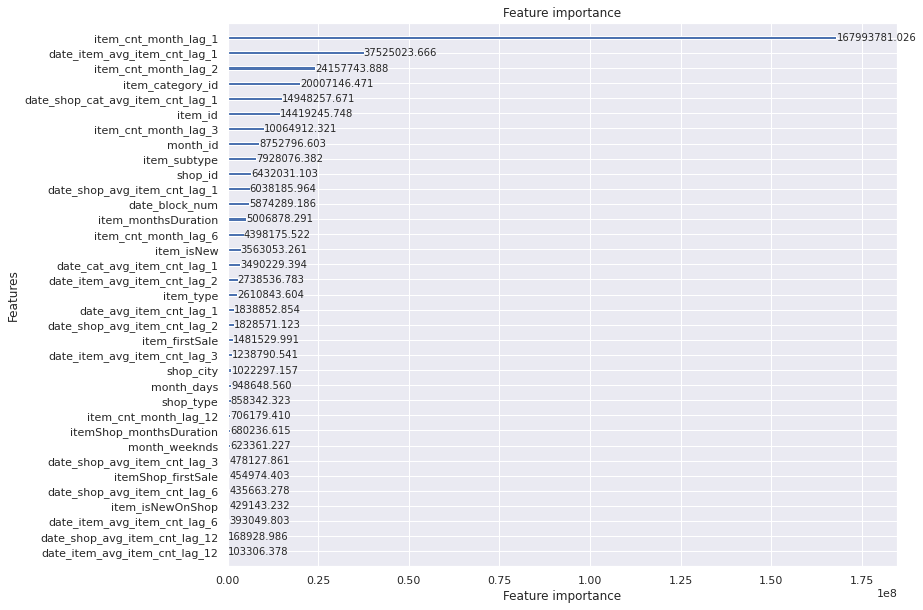

In [78]:
lgb.plot_importance(
    model, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,10));

# Entrenar con todo

In [3]:
X_train = df[df.date_block_num < 34].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 34]['item_cnt_month']

In [9]:
ts = time.time()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval  = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

evals_result = {}
model = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)
time.time() - ts

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3870
[LightGBM] [Info] Number of data points in the train set: 6353367, number of used features: 35
[LightGBM] [Info] Start training from score 0.290929
Training until validation scores don't improve for 100 rounds
[5]	training's rmse: 1.1794	valid_1's rmse: 1.12597
[10]	training's rmse: 1.16627	valid_1's rmse: 1.11589
[15]	training's rmse: 1.15344	valid_1's rmse: 1.10596
[20]	training's rmse: 1.1414	valid_1's rmse: 1.09653
[25]	training's rmse: 1.12976	valid_1's rmse: 1.08787
[30]	training's rmse: 1.11903	valid_1's rmse: 1.07984
[35]	training's rmse: 1.10894	valid_1's rmse: 1.07233
[40]	training's rmse: 1.09869	valid_1's rmse: 1.06438
[45]	training's rmse: 1.08863	valid_1's rmse: 1.05672
[50]	training's rmse: 1.07871	valid_1's rmse

[695]	training's rmse: 0.792944	valid_1's rmse: 0.839021
[700]	training's rmse: 0.792579	valid_1's rmse: 0.838759
[705]	training's rmse: 0.792204	valid_1's rmse: 0.838375
[710]	training's rmse: 0.791847	valid_1's rmse: 0.838132
[715]	training's rmse: 0.791483	valid_1's rmse: 0.837893
[720]	training's rmse: 0.791103	valid_1's rmse: 0.837656
[725]	training's rmse: 0.790758	valid_1's rmse: 0.837416
[730]	training's rmse: 0.790404	valid_1's rmse: 0.837199
[735]	training's rmse: 0.790084	valid_1's rmse: 0.836943
[740]	training's rmse: 0.78974	valid_1's rmse: 0.836748
[745]	training's rmse: 0.789406	valid_1's rmse: 0.836446
[750]	training's rmse: 0.789066	valid_1's rmse: 0.836205
[755]	training's rmse: 0.788756	valid_1's rmse: 0.836049
[760]	training's rmse: 0.788421	valid_1's rmse: 0.835758
[765]	training's rmse: 0.788098	valid_1's rmse: 0.835458
[770]	training's rmse: 0.7878	valid_1's rmse: 0.835307
[775]	training's rmse: 0.787423	valid_1's rmse: 0.835157
[780]	training's rmse: 0.787125	va

[1410]	training's rmse: 0.760228	valid_1's rmse: 0.815594
[1415]	training's rmse: 0.76007	valid_1's rmse: 0.815528
[1420]	training's rmse: 0.759956	valid_1's rmse: 0.815466
[1425]	training's rmse: 0.759785	valid_1's rmse: 0.815099
[1430]	training's rmse: 0.759653	valid_1's rmse: 0.815025
[1435]	training's rmse: 0.759491	valid_1's rmse: 0.814956
[1440]	training's rmse: 0.759348	valid_1's rmse: 0.814894
[1445]	training's rmse: 0.759225	valid_1's rmse: 0.81481
[1450]	training's rmse: 0.759073	valid_1's rmse: 0.814643
[1455]	training's rmse: 0.758959	valid_1's rmse: 0.814568
[1460]	training's rmse: 0.758803	valid_1's rmse: 0.81446
[1465]	training's rmse: 0.758677	valid_1's rmse: 0.814409
[1470]	training's rmse: 0.758531	valid_1's rmse: 0.814232
[1475]	training's rmse: 0.758414	valid_1's rmse: 0.81404
[1480]	training's rmse: 0.758297	valid_1's rmse: 0.813979
[1485]	training's rmse: 0.75817	valid_1's rmse: 0.813876
[1490]	training's rmse: 0.758054	valid_1's rmse: 0.813812
[1495]	training's r

[2125]	training's rmse: 0.743815	valid_1's rmse: 0.801384
[2130]	training's rmse: 0.743733	valid_1's rmse: 0.801344
[2135]	training's rmse: 0.743626	valid_1's rmse: 0.801277
[2140]	training's rmse: 0.743522	valid_1's rmse: 0.801202
[2145]	training's rmse: 0.743401	valid_1's rmse: 0.801098
[2150]	training's rmse: 0.743325	valid_1's rmse: 0.800967
[2155]	training's rmse: 0.743245	valid_1's rmse: 0.800933
[2160]	training's rmse: 0.743135	valid_1's rmse: 0.800882
[2165]	training's rmse: 0.74304	valid_1's rmse: 0.800834
[2170]	training's rmse: 0.742932	valid_1's rmse: 0.800746
[2175]	training's rmse: 0.742857	valid_1's rmse: 0.800704
[2180]	training's rmse: 0.742756	valid_1's rmse: 0.800656
[2185]	training's rmse: 0.742635	valid_1's rmse: 0.800503
[2190]	training's rmse: 0.742506	valid_1's rmse: 0.800446
[2195]	training's rmse: 0.742427	valid_1's rmse: 0.800401
[2200]	training's rmse: 0.74236	valid_1's rmse: 0.800356
[2205]	training's rmse: 0.742246	valid_1's rmse: 0.800269
[2210]	training'

[2835]	training's rmse: 0.732006	valid_1's rmse: 0.791713
[2840]	training's rmse: 0.731954	valid_1's rmse: 0.791687
[2845]	training's rmse: 0.731876	valid_1's rmse: 0.79157
[2850]	training's rmse: 0.731819	valid_1's rmse: 0.791537
[2855]	training's rmse: 0.731744	valid_1's rmse: 0.791446
[2860]	training's rmse: 0.731673	valid_1's rmse: 0.791417
[2865]	training's rmse: 0.731621	valid_1's rmse: 0.791391
[2870]	training's rmse: 0.73156	valid_1's rmse: 0.79135
[2875]	training's rmse: 0.731506	valid_1's rmse: 0.791316
[2880]	training's rmse: 0.731454	valid_1's rmse: 0.791285
[2885]	training's rmse: 0.731388	valid_1's rmse: 0.791254
[2890]	training's rmse: 0.731315	valid_1's rmse: 0.791216
[2895]	training's rmse: 0.731199	valid_1's rmse: 0.791073
[2900]	training's rmse: 0.731138	valid_1's rmse: 0.791042
[2905]	training's rmse: 0.731078	valid_1's rmse: 0.791012
[2910]	training's rmse: 0.73102	valid_1's rmse: 0.790947
[2915]	training's rmse: 0.730935	valid_1's rmse: 0.790868
[2920]	training's 

684.3437051773071

In [10]:
Y_test_pred = model.predict(X_test).clip(0, 20)
Y_test_pred

array([0.75192488, 1.00973291, 1.34942307, ..., 0.04489452, 0.02116959,
       0.02910757])

In [15]:
sub["item_cnt_month"] = Y_test_pred
sub

,item_cnt_month
ID,
0,0.751925
1,1.009733
2,1.349423
3,0.654111
4,0.959026
...,...
214195,0.083158
214196,0.025999
214197,0.044895


In [17]:
sub.to_csv('../../segundoModelo_submission.csv')

In [72]:
ts = time.time()
'''
#0.7875788072832439
params = {'bagging_fraction': 0.99, 'bagging_freq': 8, 'bagging_seed': SEED, 
          'feature_fraction': 0.6802441991432773, 'feature_fraction_seed': SEED, 
          'lambda_l1': 200, 'lambda_l2': 200, 'learning_rate': 0.015, 'max_bin': 176, 
          'metric': 'rmse', 'min_child_samples': 656,
          'min_child_weight': 636, 'min_split_gain': 0.1512409762978552, 'nthread': 8, 
          'num_leaves': 454, 'objective': 'mse', 'verbose': 0}
'''
SEED = 3246584
#0.7838050006725876
params = {'bagging_fraction': 0.5923685197548111, 'bagging_freq': 8, 'bagging_seed': SEED, 
          'feature_fraction': 0.6471558662772907, 'feature_fraction_seed': SEED, 
          'lambda_l1': 8, 'lambda_l2': 454, 'learning_rate': 0.15007983998456081, 'max_bin': 899, 
          'metric': 'rmse', 'min_child_samples': 463,
          'min_child_weight': 578, 'min_split_gain': 0.21257474291512948, 'nthread': 8, 
          'num_leaves': 278, 'objective': 'mse', 'verbose': 0}




evals_result = {}
model = lgb.train(params, 
            train_set=lgb.Dataset(X_train, label=Y_train), 
            num_boost_round=50000,
            valid_sets=[lgb.Dataset(X_train, label=Y_train), lgb.Dataset(X_valid, label=Y_valid)] ,
            valid_names=['train', 'val'],
            evals_result=evals_result,
            verbose_eval=50,
            early_stopping_rounds=400)
time.time() - ts

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.213747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 400 rounds


KeyboardInterrupt: 

In [ ]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In [ ]:
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=15)
plt.show()

In [ ]:
ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [ ]:
for i in range(4):
    graph = lgb.create_tree_digraph(model, tree_index=i, name='./trees/Tree' + str(i))
    graph.render(view=False)

# Predicción

In [ ]:
Y_valid_predict = model.predict(X_valid, num_iteration=model.best_iteration).clip(0, 20)

rmseAux = mean_squared_error(Y_valid, Y_valid_predict)
print (rmseAux)

submission = pd.DataFrame({
    "shop_id": X_valid['shop_id'],
    "item_id": X_valid['item_id'], 
    "item_cnt_month": Y_valid,
    "predict": Y_valid_predict,
    "predict_round": Y_valid_predict.round(),
    "difference": (Y_valid - Y_valid_predict.round())
})
submission.to_csv('lgb_submission.csv', index=False)

In [ ]:
submission['difference'].describe()

In [ ]:
print ("Nº registros: ", submission['difference'].count())
print ("Nº aciertos: ", submission[submission.difference == 0]['difference'].count())

In [ ]:
submission[submission.item_cnt_month > 3].sample(20, random_state =3333) #101, 5555, 3333

In [ ]:
ax = sns.distplot(submission['difference'])

In [ ]:
ax = sns.distplot(submission[submission.shop_id == 2]['difference'])

In [ ]:
ax = sns.distplot(submission[submission.item_id == 30]['difference'])

In [ ]:
shops = sorted(submission['shop_id'].unique().tolist())

@interact(shopid=shops)
def DiffShops(shopid):
     ax = sns.distplot(submission[submission.shop_id == shopid]['difference'])

In [ ]:
items = sorted(submission['item_id'].unique().tolist())

@interact(itemid=items)
def DiffItems(itemid):
     ax = sns.distplot(submission[submission.item_id == itemid]['difference'])